In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_classif
import pylab
import scipy
import sklearn
import time
import seaborn as sns
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objs as go

In [2]:
pd.set_option("display.max_rows", 250000)

In [3]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/GSE59114.csv', header = 1)
df1 = df.T
df1.columns = df1.loc['Gene Symbol'].reset_index()
df1 = df1.drop(['Gene Symbol', 'UCSC transcripts'])
df1.columns = [x[1] for x in df1.columns]
df1.columns = df1.columns.str.replace("'", "")
df1.shape

(1434, 8422)

Itgam, Ly6g, Ptprc, Cd3e, Ly76, Kit, Ly6a, Cd48, Slamf1

In [4]:
import re
df1_1 = df1[~df1.index.str.contains('biol_replicate')]
df1_1 = df1_1.drop(['\'Young LT-HSC\'','\'Young ST-HSC\'', '\'Young MPP\'','\'Old LT-HSC\'', '\'Old ST-HSC\'','Old MPP\''])
df1_1 = df1_1.drop(['Itgam', 'Ptprc', 'Kit', 'Ly6a', 'Cd48', 'Slamf1'], axis = 1)

In [5]:
df1_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, young_LT_HSC_2 to old_MPP_168
Columns: 8416 entries, Npl to Sft2d1
dtypes: object(8416)
memory usage: 67.9+ MB


In [6]:
df1_1.index = df1_1.index.str.replace(r'[^a-zA-Z]', '')

print((df1_1.columns).shape)
print(np.unique(df1_1.index))

(8416,)
['oldLTHSC' 'oldMPP' 'oldSTHSC' 'youngLTHSC' 'youngMPP' 'youngSTHSC']


In [7]:
df1_1dup = df1_1[df1_1.loc[:,df1_1.columns.duplicated()].columns]


In [8]:
dupcols = np.unique(df1_1dup.columns)
dupcols

array(['Abcg2', 'Arih1', 'Atf7ip', 'Atrip', 'Brwd1', 'Cbx1', 'Ccnd3',
       'Cdk6', 'Celf1', 'Commd1', 'Csnk1a1', 'Ctse', 'Dnajb6', 'Eci2',
       'Eif1ax', 'Fgd4', 'Fus', 'G3bp1', 'Glod4', 'Gm10598', 'Gm13215',
       'Hjurp', 'Ikbkb', 'Ing4', 'Itga4', 'Itga6', 'Kansl2', 'Lcor',
       'Lrrc29', 'Luc7l2', 'Mafg', 'Mecom', 'Mob1a', 'Mtcp1', 'Nagk',
       'Ndufa3', 'Pafah1b1', 'Patz1', 'Pcif1', 'Pik3ip1', 'Psme4', 'Pten',
       'Ramp2', 'Rpl24', 'Rspry1', 'Satb1', 'Smarcc2', 'Srcap', 'Srsf10',
       'Sugp2', 'Taf9', 'Tex261', 'Tmem167b', 'Tmem181b-ps', 'Trappc9',
       'Trim30b', 'U2af1l4', 'Utp23', 'Wwp2', 'Zbtb20', 'Zfp708',
       'Zfp869', 'Zgpat'], dtype=object)

In [9]:
df1_1dupgroup = df1_1dup.groupby(df1_1dup.columns, axis=1).sum()

In [10]:
df1_1dupmean = pd.DataFrame()
for x in dupcols:
    df1_1dupmean[x] = df1_1dupgroup[x]/df1_1dup.columns.tolist().count(x)


In [11]:
# cols = []
# n = 1
# for x in df2dup.columns:
#     if x in cols:
#         cols.append(x+'.'+str(n))
#         n += 1
#     else:
#         cols.append(x)
#         n = 1


In [12]:
dfnodup = df1_1.loc[:,~df1_1.columns.duplicated()].drop(dupcols, axis = 1)

df2 = pd.concat([dfnodup, df1_1dupmean], axis = 1)

df2= df2.astype(np.float64).round(2)
df2.shape

(1058, 8351)

In [13]:
dfdes = df2.astype(np.float64).describe().T
dfdes.shape

(8351, 8)

In [14]:
print('Max CV is ' + str((dfdes['std']/dfdes['mean']).max()))
print('Min CV is ' + str((dfdes['std']/dfdes['mean']).min()))

Max CV is 32.526911934581186
Min CV is 0.028750061681996453


In [260]:

varcols = dfdes[(dfdes['std']/dfdes['mean'])>2.5].index
varcols
dfvar= df2[varcols]
dfvar.shape

(1058, 1404)

In [261]:
genefracs = (dfvar==0).sum()/(dfvar==0).count()
passindex = genefracs[genefracs < .8]


In [262]:

zifavar = dfvar[passindex.index].replace(np.nan, 0)
zifavar= np.round(zifavar.astype(np.float64),4)
zifavar = np.array(zifavar)
zifavar.shape

(1058, 32)

In [263]:
from ZIFA import ZIFA
from ZIFA import block_ZIFA

In [264]:
start_time = time.time()
Z, model_params = block_ZIFA.fitModel(zifavar,5)
print("--- %s seconds ---" % (time.time() - start_time))

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1058, D = 32, K = 5, n_blocks = 1
Block sizes [32]
Param change below threshold 1.000e-02 after 13 iterations
--- 14.24540114402771 seconds ---


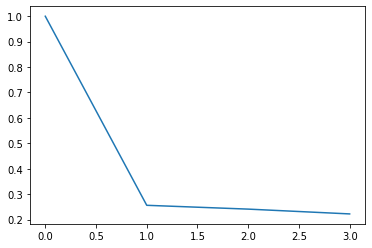

In [265]:
dfz = pd.DataFrame(Z, index = df2.index)
pcaz = PCA(n_components=3, random_state = 42)

zcomps = pcaz.fit_transform(dfz)
variance = np.insert(pcaz.explained_variance_ratio_, 0, 1)
x = [i for i in range(variance.shape[0])]

plt.plot(x, variance)


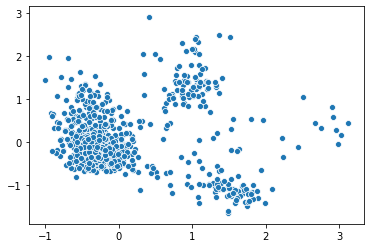

In [266]:
sns.scatterplot(zcomps[:,0], zcomps[:,1])
plt.show()

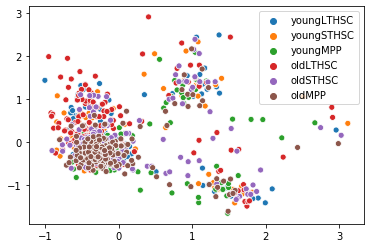

In [267]:
sns.scatterplot(zcomps[:,0], zcomps[:,1], alpha =1,hue = dfz.index)
plt.show()

In [268]:


encoded = {'oldLTHSC':0, 'oldMPP':1, 'oldSTHSC':2, 'youngLTHSC':3, 'youngMPP':4, 'youngSTHSC':5}
cells = ['oldLTHSC' ,'oldMPP', 'oldSTHSC', 'youngLTHSC' ,'youngMPP' ,'youngSTHSC']
cell_types = [encoded.get(x, x) for x in dfz.index]
colormap = ['r', 'b', 'g', 'y', 'c', 'm']
cell_colors = [colormap[x] for x in cell_types]
dfpca = pd.DataFrame(zcomps, index = dfz.index)
dfpca
fig = px.scatter_3d(dfpca, zcomps[:,0], zcomps[:,1],zcomps[:,2], dfpca.index)
fig.update_traces(marker=dict(opacity =1, size=5,
                              line=dict(width= .1)))

fig.show()


Text(0.5, 1.0, 'ZIFA-UMAP (5 dim): high variance genes (with zeros)')

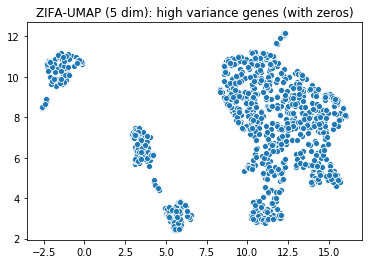

In [269]:
zumap = umap.UMAP(n_neighbors=20,
                      min_dist=.2,
                      metric='euclidean').fit_transform(dfz)
fig = sns.scatterplot(zumap[:,0], zumap[:,1])
fig.set_title('ZIFA-UMAP (5 dim): high variance genes (with zeros)')
#fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

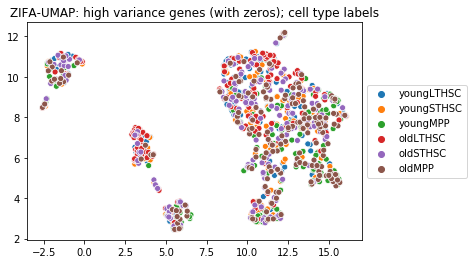

In [270]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = dfz.index)

fig.set_title('ZIFA-UMAP: high variance genes (with zeros); cell type labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [271]:
gmm = GaussianMixture(n_components = 6)
gmm.fit(dfz)
cluster = gmm.fit_predict(dfz)


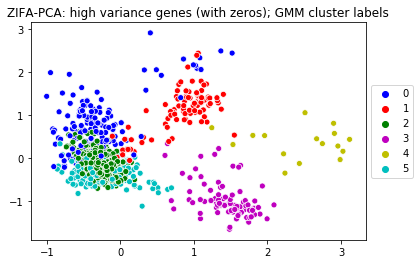

In [272]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = cluster, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA: high variance genes (with zeros); GMM cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

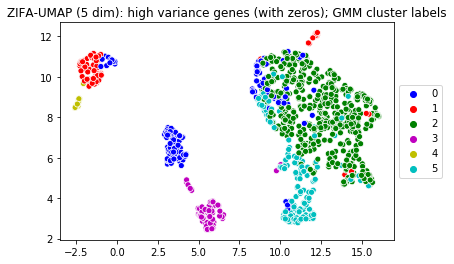

In [273]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = cluster, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): high variance genes (with zeros); GMM cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [274]:
km = KMeans(n_clusters = 6, random_state=42)
kmdata = km.fit_transform(dfz)
kpred = km.fit_predict(dfz)

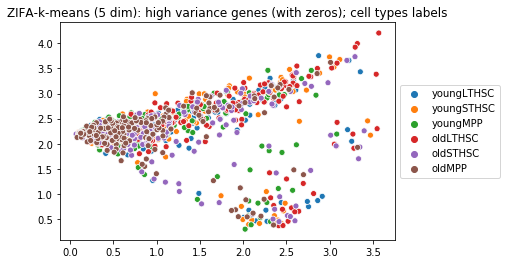

In [275]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:,1], hue = dfz.index)
fig.set_title('ZIFA-k-means (5 dim): high variance genes (with zeros); cell types labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

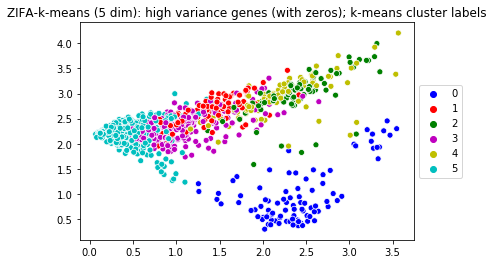

In [276]:
fig = sns.scatterplot(kmdata[:,0], kmdata[:, 1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-k-means (5 dim): high variance genes (with zeros); k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

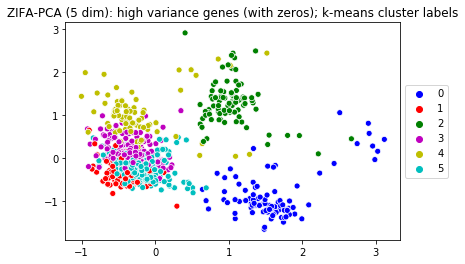

In [277]:
fig = sns.scatterplot(zcomps[:,0], zcomps[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-PCA (5 dim): high variance genes (with zeros); k-means cluster labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))


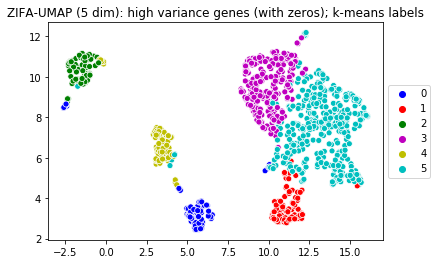

In [278]:
fig = sns.scatterplot(zumap[:,0], zumap[:,1], hue = kpred, palette =['b', 'r', 'g', 'm', 'y', 'c'])
fig.set_title('ZIFA-UMAP (5 dim): high variance genes (with zeros); k-means labels')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

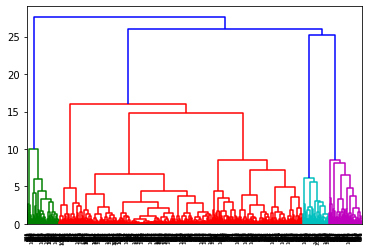

In [279]:
dendrogram(linkage(dfz, method = 'ward'))
plt.show()

In [280]:
dfcelltypes = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcelltypes['youngLTHSC'] = df2[df2.index == 'youngLTHSC'].mean()
dfcelltypes['youngSTHSC'] = df2[df2.index == 'youngSTHSC'].mean()
dfcelltypes['youngMPP'] = df2[df2.index == 'youngMPP'].mean()
dfcelltypes['oldLTHSC'] = df2[df2.index == 'oldLTHSC'].mean()
dfcelltypes['oldSTHSC'] = df2[df2.index == 'oldSTHSC'].mean()
dfcelltypes['oldMPP'] = df2[df2.index == 'oldMPP'].mean()


In [281]:
dfcellbroad = pd.DataFrame(df2.mean(), columns = ['All cell average'])
dfcellbroad['HSC'] = df2[df2.index.str.contains('HSC')].mean()
dfcellbroad['MPP'] = df2[df2.index.str.contains('MPP')].mean()
dfcellbroad['HSC/MPP'] = dfcellbroad['HSC']/dfcellbroad['MPP']
dfcellbroad.sort_values(by = ['HSC/MPP','HSC','MPP'], ascending = False).head(25000)


All cell average  \
Efna1                                                       0.643563   
Epor                                                        0.195888   
A230065H16Rik                                               0.188828   
Entpd2                                                      0.118563   
uc012bnh.1                                                  0.012618   
Chst2                                                       0.390340   
Tenc1                                                       0.414679   
Sytl5                                                       0.261078   
Smtnl1                                                      0.344102   
Fkbp10                                                      0.207335   
Trim47                                                      0.618185   
Sdpr                                                        1.132590   
Prom2                                                       0.127051   
Gstm2                                                       0.393667   
Cldn5                                                       0.133289   
Nupr1                                                       2.090359   
Gpx3                                                        0.422250   
D630039A03Rik                                               0.693374   
Plxdc2                                                      0.888459   
Clip3                                                       0.347363   
Pde6h                                                       0.221210   
uc007cvp.1,uc007cvq.1                                       0.324395   
Snrpn                                                       0.428034   
Upp1                                                        0.927183   
Gm13986                                                     0.386966   
Ndn                                                         1.065425   
Tgm2                                                        2.373488   
Sult1a1                                                     1.656285   
Hid1                                                        0.731304   
Tgfb3                                                       0.188611   
Zfp612                                                      0.548166   
Eno2                                                        0.214291   
Hba-a2                                                      0.698507   
Mt2                                                         0.389178   
Tinagl1                                                     1.058941   
Reep2                                                       0.324405   
Ehd3                                                        0.907684   
Fam46c                                                      0.120236   
Fam110c                                                     0.711323   
Abcg3                                                       2.109272   
Clca1                                                       0.969905   
Vwf                                                         1.211295   
Clec1a                                                      1.491767   
Hbb-b1                                                      0.696749   
Kazald1                                                     0.335378   
Ocln                                                        0.451739   
Rprm                                                        0.116890   
Npdc1                                                       1.094225   
Mmrn1                                                       4.407826   
Clu                                                         1.038847   
Wfdc2                                                       0.509140   
Grb10                                                       2.193034   
Rhd                                                         0.059556   
Hgfac                                                       0.722892   
Gimap4                                                      0.461730   
Abcb1a              